# StumbleUpon Evergreen Classification Challenge

This competition was found on kaggle, https://www.kaggle.com/c/stumbleupon.

Below is a brief intro to the dataset and found directly from the competition website:

*StumbleUpon is a user-curated web content discovery engine that recommends relevant, high quality pages and media to its users, based on their interests. While some pages we recommend, such as news articles or seasonal recipes, are only relevant for a short period of time, others maintain a timeless quality and can be recommended to users long after they are discovered. In other words, pages can either be classified as "ephemeral" or "evergreen". The ratings we get from our community give us strong signals that a page may no longer be relevant - but what if we could make this distinction ahead of time? A high quality prediction of "ephemeral" or "evergreen" would greatly improve a recommendation system like ours.*

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import regex as re

%matplotlib inline

# set max printout options for pandas:
pd.options.display.max_columns = 50
pd.options.display.max_colwidth = 300

In [25]:
data = './datasets/evergreen_sites.tsv'

df = pd.read_csv(data, sep='\t')
df.head(10)

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1,1,14,0,12032,162,10,0.098765,0.082569,0
5,http://www.conveniencemedical.com/genital-herp...,7018,"{""url"":""conveniencemedical genital herpes home...",?,?,119.000000,0.745455,0.581818,0.290909,0.018182,...,?,0,12,?,4368,55,3,0.054545,0.087356,0
6,http://gofashionlane.blogspot.tw/2012/06/ameri...,8685,"{""title"":""fashion lane American Wild Child "",""...",arts_entertainment,0.22111,0.773810,0.215054,0.053763,0.043011,0.043011,...,1,0,21,0,1287,93,3,0.548387,0.064327,1
7,http://www.insidershealth.com/article/racing_f...,3402,"{""url"":""insidershealth article racing for reco...",?,?,1.883333,0.719697,0.265152,0.113636,0.015152,...,?,0,5,?,27656,132,4,0.068182,0.148551,0
8,http://www.valetmag.com/the-handbook/features/...,477,"{""title"":""Valet The Handbook 31 Days 31 days"",...",?,?,0.471503,0.190722,0.036082,0.000000,0.000000,...,1,0,17,0,2471,194,7,0.644330,0.125000,1
9,http://www.howsweeteats.com/2010/03/24/cookies...,6731,"{""url"":""howsweeteats 2010 03 24 cookies and cr...",?,?,2.410112,0.469325,0.101227,0.018405,0.003067,...,?,1,14,?,11459,326,4,0.236196,0.094412,1


There are several columns with '?' which seem to indicate missing values. Let's reload the dataframe and impute the '?'s as Nans.

In [105]:
df = pd.read_csv(data, sep='\t', na_values='?')

# EDA

In [73]:
# See shape and column names
print(df.shape)
[col for col in df.columns]

(7395, 27)


['url',
 'urlid',
 'boilerplate',
 'alchemy_category',
 'alchemy_category_score',
 'avglinksize',
 'commonlinkratio_1',
 'commonlinkratio_2',
 'commonlinkratio_3',
 'commonlinkratio_4',
 'compression_ratio',
 'embed_ratio',
 'framebased',
 'frameTagRatio',
 'hasDomainLink',
 'html_ratio',
 'image_ratio',
 'is_news',
 'lengthyLinkDomain',
 'linkwordscore',
 'news_front_page',
 'non_markup_alphanum_characters',
 'numberOfLinks',
 'numwords_in_url',
 'parametrizedLinkRatio',
 'spelling_errors_ratio',
 'label']

In [74]:
# Check for Nan counts and columns
df.isnull().sum()

url                                  0
urlid                                0
boilerplate                          0
alchemy_category                  2342
alchemy_category_score            2342
avglinksize                          0
commonlinkratio_1                    0
commonlinkratio_2                    0
commonlinkratio_3                    0
commonlinkratio_4                    0
compression_ratio                    0
embed_ratio                          0
framebased                           0
frameTagRatio                        0
hasDomainLink                        0
html_ratio                           0
image_ratio                          0
is_news                           2843
lengthyLinkDomain                    0
linkwordscore                        0
news_front_page                   1248
non_markup_alphanum_characters       0
numberOfLinks                        0
numwords_in_url                      0
parametrizedLinkRatio                0
spelling_errors_ratio    

0.625616

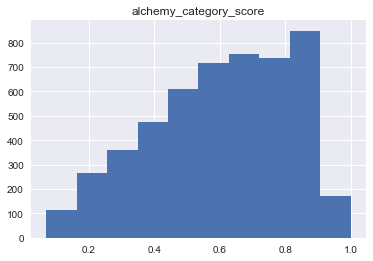

In [79]:
df.hist('alchemy_category_score')

Below is how I interpret and will impute the missing values,<br/><br/>
alchemy_category -> 'unknown' (Categorical)<br/> 
alchemy_category_score -> Impute mean<br/>
is_news -> 0 (binary)<br/>
news_front_page -> -1 (Categorical)

In [106]:
df['alchemy_category'].fillna('unknown', inplace=True)
df['alchemy_category_score'].fillna(df['alchemy_category_score'].mean(), inplace=True)
df['is_news'].fillna(0, inplace=True)
df['news_front_page'].fillna(-1, inplace=True)

The 'boilerplate' column looks to have text data- let's take a look.

In [107]:
df['boilerplate'][0][:500]

'{"title":"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries","body":"A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose California Photographer Tony Avelar Bloomberg By 2015 your mobile phone will project a 3 '

It looks to be formatted as a JSON dictionary so we'll sepearate this column into 2 features.

In [108]:
df['title'] = df['boilerplate'].map(lambda x: json.loads(x).get('title', ''))
df['body'] = df['boilerplate'].map(lambda x: json.loads(x).get('body', ''))

Let's try to see what 'evergreen' is by reading some titles.

In [97]:
df[['title', 'label']].head()

,title,label
0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",0
1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",1
2,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,1
3,10 Foolproof Tips for Better Sleep,1
4,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,0


Just by looking at the top 5 row titles, it looks like topics that deal with current events or topics that hit a more niche group of people (jerseys) aren't considered evergreen. 

Would website category affect green-ness?

alchemy_category
arts_entertainment    0.371945
business              0.711364
computer_internet     0.246622
culture_politics      0.457726
gaming                0.368421
health                0.573123
law_crime             0.419355
recreation            0.684296
religion              0.416667
science_technology    0.456747
sports                0.205263
unknown               0.501704
weather               0.000000
Name: label, dtype: float64


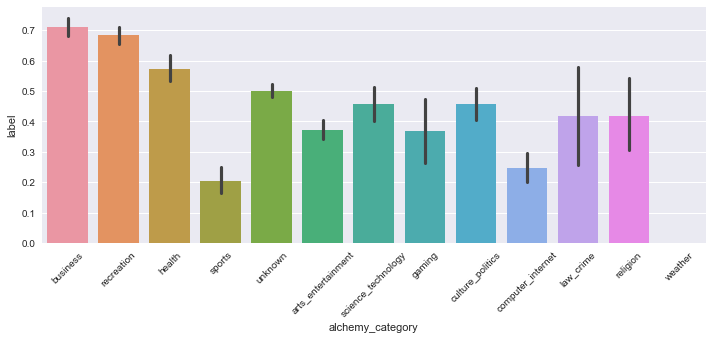

In [109]:
print(df.groupby('alchemy_category').mean()['label'])

sns.factorplot(x='alchemy_category', y='label', data=df, kind='bar', \
               aspect=2.5).set_xticklabels(rotation=45)

There seems to be a good relationship with category and green-ness. Looking at the above chart the results make sense. For exammple, I would think business related web pages can have value in the future as sports are closer to current event type pages.

In [113]:
df.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html,4042,"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1.0,1,24,0.0,5424,170,8,0.152941,0.079130,0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose Califor...
1,http://www.popsci.com/technology/article/2012-07/electronic-futuristic-starting-gun-eliminates-advantages-races,8471,"{""title"":""The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races"",""body"":""And that can be carried on a pla...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1.0,1,40,0.0,4973,187,9,0.181818,0.125448,1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",And that can be carried on a plane without the hassle too The Omega E Gun Starting Pistol Omega It s easy to take for granted just how insanely close some Olympic races are and how much the minutiae of it all can matter The perfect example is the traditional starting gun Seems easy You pull a tr...
2,http://www.menshealth.com/health/flu-fighting-fruits?cm_mmc=Facebook-_-MensHealth-_-Content-Health-_-FightFluWithFruit,1164,"{""title"":""Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health"",""body"":""Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent hea...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1.0,1,55,0.0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent heart disease and cancer Next Papayas With 250 percent of the RDA of vitamin C a papaya can help kick ...
3,http://www.dumblittleman.com/2007/12/10-foolproof-tips-for-better-sleep.html,6684,"{""title"":""10 Foolproof Tips for Better Sleep "",""body"":""There was a period in my life when I had a lot of problems with sleep It took me very long to fall asleep I was easily awaken and I simply wasn t getting enough of rest at night I didn t want to take medication and this led me to learn sever...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1.0,0,24,0.

In [114]:
# Set feature matrix and target vectors
X = df.drop(['url', 'urlid', 'boilerplate'], axis=1)
y = df['label']

In [115]:
X.head()

,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,title,body
0,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1.0,1,24,0.0,5424,170,8,0.152941,0.079130,0,"IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries",A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose Califor...
1,recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1.0,1,40,0.0,4973,187,9,0.181818,0.125448,1,"The Fully Electronic Futuristic Starting Gun That Eliminates Advantages in Races the fully electronic, futuristic starting gun that eliminates advantages in races the fully electronic, futuristic starting gun that eliminates advantages in races",And that can be carried on a plane without the hassle too The Omega E Gun Starting Pistol Omega It s easy to take for granted just how insanely close some Olympic races are and how much the minutiae of it all can matter The perfect example is the traditional starting gun Seems easy You pull a tr...
2,health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1.0,1,55,0.0,2240,258,11,0.166667,0.057613,1,Fruits that Fight the Flu fruits that fight the flu | cold & flu | men's health,Apples The most popular source of antioxidants in our diet one apple has an antioxidant effect equivalent to 1 500 mg of vitamin C Apples are loaded with protective flavonoids which may prevent heart disease and cancer Next Papayas With 250 percent of the RDA of vitamin C a papaya can help kick ...
3,health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1.0,0,24,0.0,2737,120,5,0.041667,0.100858,1,10 Foolproof Tips for Better Sleep,There was a period in my life when I had a lot of problems with sleep It took me very long to fall asleep I was easily awaken and I simply wasn t getting enough of rest at night I didn t want to take medication and this led me to learn several tips and tricks that really helped me to overcome my...
4,sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1.0,1,14,0.0,12032,162,10,0.098765,0.082569,0,The 50 Coolest Jerseys You Didn t Know Existed coolest jerseys you haven't seen,Jersey sales is a curious business Whether you re buying the stylish top to represent your favorite team player or color you re always missing out on better artwork With No 18 Colts jerseys continuing to flood the streets it s about time we educate the sports public about the real masterpieces t...
